In [1]:
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Get data from OpenPrescribing GBG measure equivalent view

In [2]:
sql = """
SELECT
  month,
  pct,
  practice,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
GROUP BY
  month,
  pct,
  practice
"""
ghost_df = bq.cached_read(sql, csv_path='ghost_generics.zip')

In [3]:
ghost_df.head()

,month,pct,practice,items,possible_savings,net_cost
0,2015-08-01,06N,E82020,3,-15.6060,37280.74
1,2015-08-01,00X,P81010,5,3.6495,29541.43
2,2015-08-01,01A,P81620,0,0.0000,7382.23
3,2015-08-01,00V,P83620,12,0.0690,34162.02
4,2015-08-01,00V,P83005,1,2.9450,35156.08


# Practice level data

In [4]:
practice = ghost_df.copy()
practice['calc_val'] = practice['possible_savings']/practice['net_cost']
practice['month'] = pd.to_datetime(practice['month'])
practice = practice.sort_values(['practice','month'])
practice = practice.loc[practice['month']>='2010-11-01']
practice = practice.replace([np.inf, -np.inf], np.nan)
practice.head()

,month,pct,practice,items,possible_savings,net_cost,calc_val
625509,2010-11-01,00K,A81001,24,14.2020,29841.59,0.000476
47846,2010-12-01,00K,A81001,87,41.9030,30287.68,0.001383
539767,2011-01-01,00K,A81001,30,-18.5990,29670.45,-0.000627
229229,2011-02-01,00K,A81001,38,-21.5494,27586.82,-0.000781
615119,2011-03-01,00K,A81001,89,251.3024,34156.80,0.007357


# CCG level data

In [5]:
ccg = ghost_df.copy()
ccg['month'] = pd.to_datetime(ccg['month'])
ccg = ccg.groupby(['pct','month'],as_index=False).sum()
ccg['calc_val'] = ccg['possible_savings']/ccg['net_cost']
ccg = ccg.sort_values(['pct','month'])
ccg = ccg.loc[ccg['month']>='2010-11-01']
ccg = ccg.replace([np.inf, -np.inf], np.nan)
ccg.head()

,pct,month,items,possible_savings,net_cost,calc_val
3,00C,2010-11-01,2422,1652.8864,752002.40,0.002198
4,00C,2010-12-01,3485,4322.9984,814387.27,0.005308
5,00C,2011-01-01,2460,3528.5246,746725.43,0.004725
6,00C,2011-02-01,968,549.6110,747591.43,0.000735
7,00C,2011-03-01,3085,2274.7350,839138.56,0.002711


In [34]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [36]:
## here we calculate ranges for december 2012
ccg_dec18 = ccg.copy().loc[(ccg["month"]== "2018-12-01")]
ccg_dec18.describe()

,items,possible_savings,net_cost,calc_val
count,196.00,196.00,196.00,196.00
mean,14252.16,4430.38,1784261.53,0.00
std,20319.74,6088.59,1046548.64,0.00
min,71.00,-197.52,50003.30,-0.00
25%,568.50,72.26,1150486.67,0.00
50%,4477.50,1590.20,1523225.40,0.00
75%,21404.00,6701.10,2073027.21,0.00
max,142769.00,34664.49,7234775.70,0.02


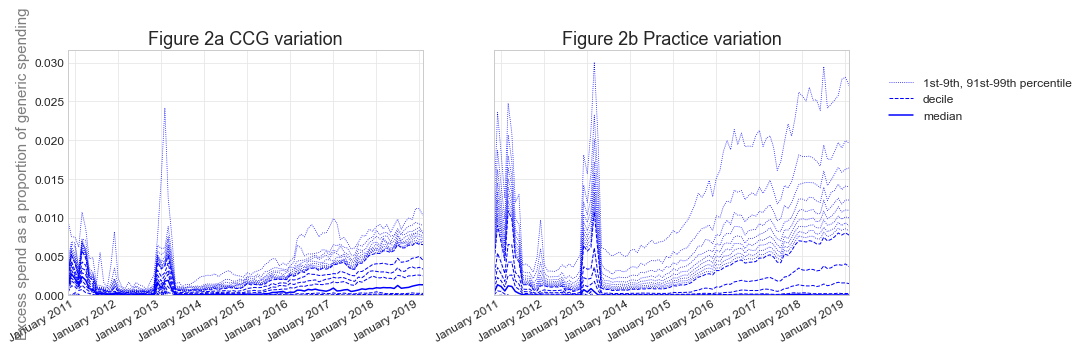

In [27]:
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 
# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)  

charts.deciles_chart(
    ccg,
    period_column='month',
    column='calc_val',
    title="Figure 2a CCG variation",
    ylabel="Excess spend as a proportion of generic spending",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot
)

charts.deciles_chart(
    practice,
    period_column='month',
    column='calc_val',
    title="Figure 2b Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot
)
plt.show()

# Most recent month map
- I think still some missing CCGs here?

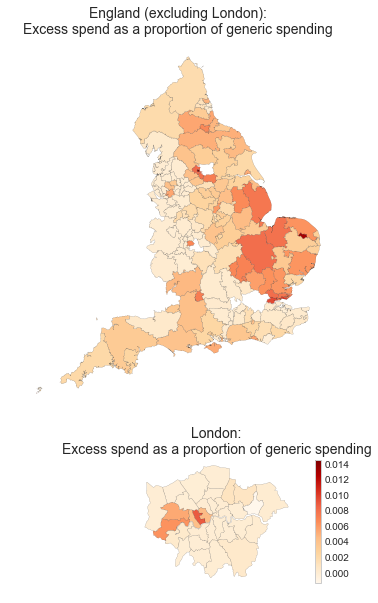

In [7]:
plt.figure(figsize=(7, 10))
last_month = ccg.loc[ccg['month']==ccg['month'].max()]
maps.ccg_map(last_month, title="Excess spend as a proportion of generic spending", column='calc_val', 
             separate_london=True)
plt.show()

# Total items and total excess costs

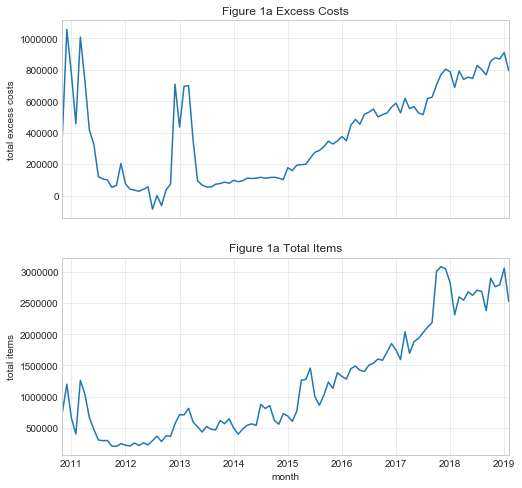

In [8]:
f = plt.figure(figsize=(8, 8))
layout = gridspec.GridSpec(2, 1, figure=f)
top_plot = plt.subplot(layout[0])
bottom_plot = plt.subplot(layout[1], sharex=top_plot)  # Share the Y axis 

ax = practice.groupby('month').sum()['possible_savings'].plot(ax=top_plot)
ax.set_ylabel('total excess costs')
ax.set_title('Figure 1a Excess Costs')
ax = practice.groupby('month').sum()['items'].plot(ax=bottom_plot)
ax.set_ylabel('total items')
ax.set_title('Figure 1a Total Items')
plt.show()

# Stratify by EHR

In [9]:
epr = pd.read_csv("gpsoc_marketshare_201801b.csv.gz", compression='gzip', usecols=['ODS', 'Principal Supplier', 'Principal System'])
epr.head()

,ODS,Principal Supplier,Principal System
0,A81023,TPP,SystmOne
1,A81048,TPP,SystmOne
2,A82018,EMIS,EMIS Web
3,A84043,TPP,SystmOne
4,A86026,TPP,SystmOne


In [10]:
numbers = practice[['month','practice', 'possible_savings','net_cost']]
by_epr = numbers.merge(epr, how='inner', left_on='practice', right_on='ODS')
by_epr = by_epr.groupby(['month','Principal Supplier']).sum()
by_epr = by_epr.unstack()
by_epr.head()

possible_savings                                      \
Principal Supplier             EMIS  Microtest          TPP      Vision   
month                                                                     
2010-11-01              205167.2547  -405.6494  133074.3461  20817.4751   
2010-12-01              590956.0904   -81.0722  350603.9563  55254.5589   
2011-01-01              416579.8189  -467.4578  269670.0517  48624.8674   
2011-02-01              249928.7177  -439.3642  156969.5211  25063.1928   
2011-03-01              537635.2722 -4248.3987  374247.2258  50055.2778   

                        net_cost                                         
Principal Supplier          EMIS   Microtest           TPP       Vision  
month                                                                    
2010-11-01          1.795642e+08  2783101.86  1.221164e+08  15094606.35  
2010-12-01          1.913645e+08  2965208.10  1.301516e+08  15953455.51  
2011-01-01          1.795575e+08  2719849.86  1.215787e+08  15214924.94  
2011-02-01          1.756294e+08  2717094.64  1.190238e+08  14769089.72  
2011-03-01          1.991831e+08  3047613.86  1.353099e+08  16672611.40

## Total possible savings

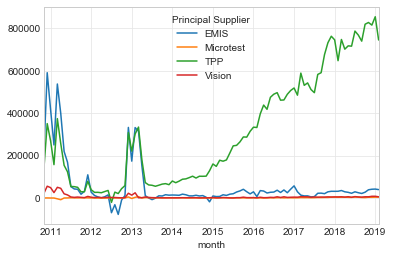

In [11]:
by_epr['possible_savings'].plot()
plt.show()

In [12]:
measure = by_epr['possible_savings'] / by_epr['net_cost']
measure.head()

Principal Supplier,EMIS,Microtest,TPP,Vision
month,,,,
2010-11-01,0.001143,-0.000146,0.001090,0.001379
2010-12-01,0.003088,-0.000027,0.002694,0.003463
2011-01-01,0.002320,-0.000172,0.002218,0.003196
2011-02-01,0.001423,-0.000162,0.001319,0.001697
2011-03-01,0.002699,-0.001394,0.002766,0.003002


## Total savings/total generic prescribing costs

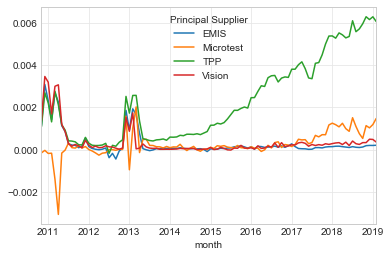

In [13]:
measure.plot()

# Map of weird spike in 2010/11

In [17]:
weird.sort_values('calc_val',ascending=False)

,items,possible_savings,net_cost,calc_val
pct,,,,
10J,18230,31471.2180,5305120.06,0.005932
00V,18028,38635.5484,6523366.07,0.005923
12D,17739,32306.9880,5995724.56,0.005388
15D,25908,52735.3289,9900932.26,0.005326
00D,32866,58075.6505,10960917.16,0.005298
06P,11804,28848.0661,5588225.97,0.005162
01E,15575,32886.6991,6466181.02,0.005086
12F,26786,51995.1419,10458701.12,0.004971
99K,15354,25608.9723,5220557.89,0.004905


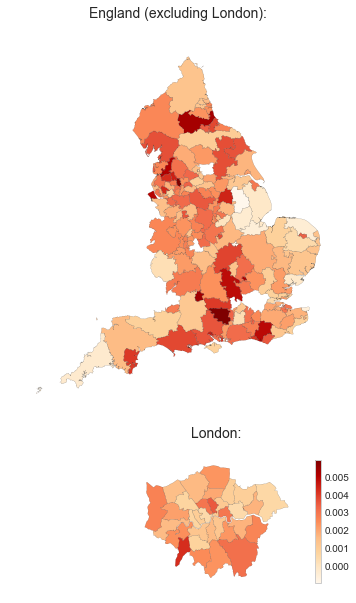

In [16]:
plt.figure(figsize=(7, 10))
weird = practice.merge(epr, how='inner', left_on='practice', right_on='ODS')
weird = weird.loc[(weird['month']>='2010-12-01') & (weird['month']<='2011-04-01')]
weird = weird.groupby('pct').sum()
weird['calc_val'] = weird['possible_savings']/weird['net_cost']
maps.ccg_map(weird, title="", column='calc_val', 
             separate_london=True)
plt.show()

# Map of weird spike in 2012/13

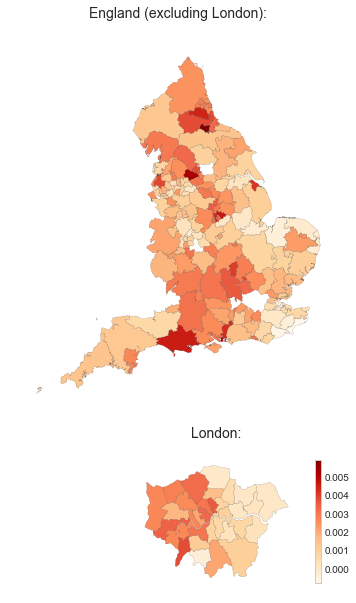

In [18]:
plt.figure(figsize=(7, 10))
weird = practice.merge(epr, how='inner', left_on='practice', right_on='ODS')
weird = weird.loc[(weird['month']>='2012-12-01') & (weird['month']<='2013-03-01')]
weird = weird.groupby('pct').sum()
weird['calc_val'] = weird['possible_savings']/weird['net_cost']
maps.ccg_map(weird, title="", column='calc_val', 
             separate_london=True)
plt.show()

# Top presentations causing the weird spikes

## 2010/11

In [19]:
sql = """
SELECT
  bnf_code,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
WHERE
  month >= '2010-12-01'
  AND month <= '2011-04-01'
GROUP BY
  bnf_code
ORDER BY
  possible_savings DESC
"""
by_bnf = bq.cached_read(sql, csv_path='by_bnf.zip')

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


In [20]:
by_bnf['calc_val'] = by_bnf['possible_savings'] / by_bnf['net_cost']
by_bnf.head()

,bnf_code,items,possible_savings,net_cost,calc_val
0,0403030Q0AAABAB,407993,1.020202e+06,3311976.29,0.308034
1,0403030D0AAAAAA,1918108,7.382023e+05,16617143.90,0.044424
2,0408010G0AAACAC,29553,5.134045e+05,932539.36,0.550545
3,0603020T0AAACAC,447815,5.116647e+05,7073123.35,0.072339
4,0403030Q0AAAAAA,302819,4.810360e+05,9298274.20,0.051734


## 2012/13

In [21]:
sql = """
SELECT
  bnf_code,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
WHERE
  month >= '2012-12-01'
  AND month <= '2013-03-01'
GROUP BY
  bnf_code
ORDER BY
  possible_savings DESC
"""
by_bnf2 = bq.cached_read(sql, csv_path='by_bnf.zip')

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


In [22]:
by_bnf2['calc_val'] = by_bnf2['possible_savings'] / by_bnf2['net_cost']
by_bnf2.head()

,bnf_code,items,possible_savings,net_cost,calc_val
0,0403030Q0AAABAB,263951,612007.2609,3531618.17,0.173294
1,0202010P0AAAAAA,190060,482030.1624,2466489.87,0.195432
2,0401010T0AAAMAM,265972,416504.1109,8394572.88,0.049616
3,0401010T0AAANAN,76216,248136.2482,2555089.58,0.097115
4,0403010X0AAABAB,47582,182968.5589,933233.58,0.196059


# Dorset

In [23]:
sql = 'SELECT code, name FROM ebmdatalab.hscic.practices'
practice_names = bq.cached_read(sql, csv_path='practice_names.zip')
practice_names.head()

C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,code,name
0,09X999,None
1,NHT999,None
2,04R999,None
3,04E999,None
4,NL1999,None


In [24]:
pd.set_option('display.max_rows', 500)
dorset = practice.loc[practice['pct']=='11J']
dorset = dorset.merge(practice_names, how='left', left_on='practice', right_on='code')
dorset.head()

,month,pct,practice,items,possible_savings,net_cost,calc_val,code,name
0,2010-11-01,11J,J81002,115,78.5615,71731.04,0.001095,J81002,ORCHID HOUSE SURGERY
1,2010-12-01,11J,J81002,209,121.3408,72358.89,0.001677,J81002,ORCHID HOUSE SURGERY
2,2011-01-01,11J,J81002,67,55.8720,74558.22,0.000749,J81002,ORCHID HOUSE SURGERY
3,2011-02-01,11J,J81002,58,-35.2574,69001.70,-0.000511,J81002,ORCHID HOUSE SURGERY
4,2011-03-01,11J,J81002,202,140.2469,78240.67,0.001793,J81002,ORCHID HOUSE SURGERY


## 2010/11

In [25]:
dorset_10_11 =  dorset.loc[(dorset['month']>='2010-12-01') & (dorset['month']<='2011-04-01')]
dorset_10_11 = dorset_10_11.groupby(['practice','name']).sum()
dorset_10_11['calc_val'] = dorset_10_11['possible_savings'] / dorset_10_11['net_cost']
dorset_10_11.sort_values('possible_savings',ascending=False)

,,items,possible_savings,net_cost,calc_val
practice,name,,,,
J81014,WESTBOURNE MEDICAL CENTRE,1409,4507.0789,512894.65,0.008788
J81054,LILLIPUT SURGERY,685,4346.7488,281819.90,0.015424
J81077,WALFORD MILL MEDICAL CENTRE,700,2920.8223,179119.74,0.016307
J81018,BEAUFORT ROAD SURGERY,957,2889.0879,350235.30,0.008249
J81059,SOUTHBOURNE PRACTICE,776,2738.0509,253224.92,0.010813
J81033,TALBOT MEDICAL CENTRE,1095,2633.7641,289670.91,0.009092
J81027,ROYAL CRESCENT SURGERY,1524,2603.3132,561554.91,0.004636
J81041,THE HADLEIGH PRACTICE,1324,2412.8577,501995.18,0.004807
J81056,CHRISTCHURCH MEDICAL PRACTICE,696,2375.0579,252101.80,0.009421


## 2012/13

In [26]:
dorset_12_13 =  dorset.loc[(dorset['month']>='2012-12-01') & (dorset['month']<='2013-03-01')]
dorset_12_13 = dorset_12_13.groupby(['practice','name']).sum()
dorset_12_13['calc_val'] = dorset_12_13['possible_savings'] / dorset_12_13['net_cost']
dorset_12_13.sort_values('possible_savings',ascending=False)

,,items,possible_savings,net_cost,calc_val
practice,name,,,,
J81066,STOUR SURGERY,2304,4257.3268,246964.76,0.017239
J81014,WESTBOURNE MEDICAL CENTRE,1190,3992.7104,369852.40,0.010795
J81006,THE ADAM PRACTICE,924,3568.2033,696439.15,0.005123
J81027,ROYAL CRESCENT SURGERY,914,3560.3381,486003.49,0.007326
J81018,BEAUFORT ROAD SURGERY,598,3359.4809,271299.59,0.012383
J81054,LILLIPUT SURGERY,343,3130.7217,201813.97,0.015513
J81065,MADEIRA MEDICAL CENTRE,981,2618.5487,180155.35,0.014535
J81034,QUARTERJACK SURGERY,1638,2383.9188,343984.65,0.006930
J81013,CANFORD HEATH GROUP PRACT,399,2148.4318,246077.38,0.008731
